### Рассмотреть понятие рекомендательных систем. Что такое? Где используется?

Рекомендательные системы — это программы, которые осуществляют подбор товаров, услуг или контента и предлагают их пользователям. Они анализируют данные о пользователях и предсказывают их интересы.

Области применения:
* Видео- и аудиостриминг (Netflix, YouTube, Spotify)
* Социальные сети (Instagram, TikTok, Facebook)
* Образовательные платформы (Coursera, Udemy)

### Рассмотреть основные виды рекомендательных систем: фильтрация по содержимому, совместная фильтрация (на основе близости, на основе модели), гибридная фильтрация. (Дополнительно можно рассмотреть: контекстные рекомендации, неперсонализированные рекомендации).

Основные виды рекомендательных систем
1. Фильтрация по содержимому (Content-based)

- Принцип: Рекомендации на основе характеристик объектов и предпочтений пользователя
- Процесс: Создание профиля пользователя → сопоставление с атрибутами объектов
- Преимущества: Не требует данных о других пользователях, прозрачность рекомендаций
- Недостатки: "Пузырь фильтров" (ограничение пользователя контентом, похожим на ранее просмотренный, что снижает разнообразие рекомендаций), необходимость качественных данных
- Примеры: Рекомендации статей, документов, научных публикаций

2. Совместная фильтрация (Collaborative)
На основе близости (Memory-based)

- User-based: Рекомендации на основе схожести пользователей
- Item-based: Рекомендации на основе схожести объектов
- Метрики: косинусное сходство (мера подобия между векторами, определяемая как косинус угла между ними; используется для определения схожести предпочтений пользователей или объектов независимо от масштаба оценок), корреляция Пирсона
- Недостатки: проблема холодного старта (сложность рекомендаций для новых пользователей или объектов без истории взаимодействий), разреженность данных (большинство пользователей взаимодействует лишь с малой частью всех доступных объектов)

На основе модели (Model-based)

- Техники: матричная факторизация, SVD, нейронные сети
- Преимущества: лучше масштабируется, решает проблему разреженности
- Примеры: Netflix Prize, системы рекомендации товаров

3. Гибридная фильтрация (Hybrid)

- Подходы: взвешенный, каскадный, переключаемый, смешанный
- Преимущества: компенсирует недостатки отдельных методов
- Примеры: YouTube, Netflix, Amazon, Spotify

### Рассмотреть: многоцелевую оптимизацию, архитектуру рекомендательных систем.

1. Многоцелевая оптимизация
Суть: Одновременная оптимизация нескольких, часто конфликтующих, целей рекомендательной системы.

Основные цели:

- Релевантность (точность прогноза)
- Разнообразие рекомендаций
- Новизна контента
- Охват каталога
- Справедливость рекомендаций
- Вычислительная эффективность
- Прибыль/конверсия

Методы:

- Взвешенная сумма целевых функций
- Парето-оптимальные решения
- Ограничения на определенные метрики
- Многослойные модели с разными целями на каждом уровне

2. Архитектура рекомендательных систем
Основные компоненты:

- Сбор данных
- Предобработка: нормализация, фильтрация
- Хранение данных: реляционные БД, NoSQL, распределенные системы
- Обучение моделей
- Генерация кандидатов: отбор потенциальных рекомендаций из каталога
- Ранжирование: упорядочивание кандидатов по релевантности
- Постобработка: фильтрация, разнообразие
- Серверная инфраструктура / MLOps
- Система обратной связи: сбор метрик, A/B-тестирование

In [13]:
from typing import Tuple, Dict, List
from sklearn.model_selection import train_test_split as sk_train_test_split
import pandas as pd
import os


class MovieLensDataLoader:
    def __init__(self, data_path: str):
        self.data_path = data_path
        self.ratings = None
        self.movies = None
        self.users = None

    def load_data(self) -> None:
        self.ratings = pd.read_csv(
            os.path.join(self.data_path, 'u.data'),
            sep='\t',
            names=['userId', 'movieId', 'rating', 'timestamp'],
            encoding='latin-1'
        )

        self.movies = pd.read_csv(
            os.path.join(self.data_path, 'u.item'),
            sep='|',
            encoding='latin-1',
            names=['movieId', 'title', 'release_date', 'video_release_date', 'imdb_url'] +
                  [f'genre_{i}' for i in range(19)]
        )

        self.users = pd.read_csv(
            os.path.join(self.data_path, 'u.user'),
            sep='|',
            names=['userId', 'age', 'gender', 'occupation', 'zip_code'],
            encoding='latin-1'
        )

        print(f"Загружено {len(self.ratings)} оценок для {len(self.ratings['userId'].unique())} "
              f"пользователей и {len(self.ratings['movieId'].unique())} фильмов.")

    def get_train_test_split(self, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
        if self.ratings is None:
            self.load_data()

        train, test = sk_train_test_split(
            self.ratings,
            test_size=test_size,
            random_state=random_state
        )
        return train, test

    def get_genre_features(self) -> Dict[int, List[str]]:
        if self.movies is None:
            self.load_data()

        genres = self.movies[[f'genre_{i}' for i in range(19)]].values
        return {
            movie_id: [f"genre_{i}" for i, has_genre in enumerate(genre_vector) if has_genre == 1]
            for movie_id, genre_vector in zip(self.movies['movieId'], genres)
        }

    def get_user_features(self) -> Dict[int, List[str]]:
        if self.users is None:
            self.load_data()

        return {
            user_id: [f"gender_{gender}", f"occupation_{occupation}", f"age_group_{age // 10}"]
            for user_id, age, gender, occupation in
            zip(self.users['userId'], self.users['age'], self.users['gender'], self.users['occupation'])
        }

    def get_movie_title_by_id(self, movie_id: int) -> str:
        if self.movies is None:
            self.load_data()
        return self.movies[self.movies['movieId'] == movie_id]['title'].values[0]


In [14]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD, KNNBasic, NMF, accuracy
import numpy as np

class SurpriseRecommender:
    def __init__(self, data_loader: MovieLensDataLoader, model_type: str = 'svd'):
        self.name = f"Surprise_{model_type}"
        self.data_loader = data_loader
        self.model_type = model_type
        self.model = None
        self.is_trained = False
        self.metrics = {}
        self.reader = None
        self.dataset = None
        self.train_set = None
        self.test_set = None

    def prepare_data(self) -> None:
        self.data_loader.load_data()
        self.reader = Reader(rating_scale=(1, 5))
        self.dataset = Dataset.load_from_df(
            self.data_loader.ratings[['userId', 'movieId', 'rating']],
            self.reader
        )

        self.train_set, self.test_set = train_test_split(self.dataset, test_size=0.2, random_state=42)

    def train(self) -> None:
        if self.train_set is None:
            self.prepare_data()

        if self.model_type == 'svd':
            self.model = SVD(random_state=42)
        elif self.model_type == 'knn_user':
            self.model = KNNBasic(sim_options={'user_based': True})
        elif self.model_type == 'knn_item':
            self.model = KNNBasic(sim_options={'user_based': False})
        elif self.model_type == 'nmf':
            self.model = NMF(random_state=42)
        else:
            raise ValueError(f"Неизвестный тип модели: {self.model_type}")

        self.model.fit(self.train_set)
        self.is_trained = True

    def evaluate(self) -> Dict[str, float]:
        if not self.is_trained:
            self.train()

        predictions = self.model.test(self.test_set)
        rmse = accuracy.rmse(predictions)
        mae = accuracy.mae(predictions)

        self.metrics = {
            'RMSE': rmse,
            'MAE': mae
        }

        return self.metrics

    def recommend(self, user_id: int, n_recommendations: int = 10) -> pd.DataFrame:
        if not self.is_trained:
            self.train()

        user_ratings = self.data_loader.ratings[
            self.data_loader.ratings['userId'] == user_id
            ]['movieId'].unique()

        all_movies = self.data_loader.ratings['movieId'].unique()
        movies_to_predict = np.setdiff1d(all_movies, user_ratings)

        recs = [(movie_id, self.model.predict(user_id, movie_id).est)
                for movie_id in movies_to_predict]

        recs = sorted(recs, key=lambda x: x[1], reverse=True)[:n_recommendations]

        recommendations = pd.DataFrame(recs, columns=['movieId', 'predicted_rating'])
        recommendations['title'] = recommendations['movieId'].apply(
            lambda x: self.data_loader.get_movie_title_by_id(x)
        )
        return recommendations[['movieId', 'title', 'predicted_rating']]

In [16]:


from matplotlib import pyplot as plt
from typing import Optional


class RecommenderEvaluator:
    def __init__(self):
        self.recommenders = []
        self.metrics = {}

    def add_recommender(self, recommender) -> None:
        self.recommenders.append(recommender)

    def evaluate_all(self) -> Dict[str, Dict[str, float]]:
        for recommender in self.recommenders:
            self.metrics[recommender.name] = recommender.evaluate()

        return self.metrics

    def compare_recommendations(self, user_id: int, n_recommendations: int = 10) -> Dict[str, pd.DataFrame]:
        recommendations = {}

        for recommender in self.recommenders:
            recommendations[recommender.name] = recommender.recommend(
                user_id, n_recommendations
            )

        return recommendations

    def plot_metrics(self, metric_name: Optional[str] = None) -> None:
        if not self.metrics:
            self.evaluate_all()

        if metric_name:
            metrics = {}
            for name, model_metrics in self.metrics.items():
                if metric_name in model_metrics:
                    metrics[name] = model_metrics[metric_name]

            plt.figure(figsize=(10, 6))
            plt.bar(metrics.keys(), metrics.values())
            plt.title(f'Сравнение метрики {metric_name}')
            plt.ylabel(metric_name)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            metrics_to_plot = set()
            for model_metrics in self.metrics.values():
                metrics_to_plot.update(model_metrics.keys())

            fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 5 * len(metrics_to_plot)))

            for i, metric in enumerate(sorted(metrics_to_plot)):
                ax = axes[i] if len(metrics_to_plot) > 1 else axes

                metrics = {}
                for name, model_metrics in self.metrics.items():
                    if metric in model_metrics:
                        metrics[name] = model_metrics[metric]

                ax.bar(metrics.keys(), metrics.values())
                ax.set_title(f'Сравнение метрики {metric}')
                ax.set_ylabel(metric)
                ax.tick_params(axis='x', rotation=45)

            plt.tight_layout()
            plt.show()

    def find_common_recommendations(self, recommendations: Dict[str, pd.DataFrame]) -> pd.DataFrame:
        common_movies = set()
        is_first = True

        for name, recs in recommendations.items():
            movies = set(recs['movieId'])
            if is_first:
                common_movies = movies
                is_first = False
            else:
                common_movies &= movies

        common_df = pd.DataFrame({'movieId': list(common_movies)})

        for name, recs in recommendations.items():
            score_col = 'predicted_rating' if 'predicted_rating' in recs.columns else 'predicted_score'
            common_df = common_df.merge(
                recs[['movieId', score_col]].rename(columns={score_col: f'{name}_score'}),
                on='movieId'
            )
        if len(self.recommenders) > 0:
            common_df['title'] = common_df['movieId'].apply(
                lambda x: self.recommenders[0].data_loader.get_movie_title_by_id(x)
            )

        return common_df

In [17]:
data_loader = MovieLensDataLoader("ml-100k")

In [18]:
data_loader.load_data()

Загружено 100000 оценок для 943 пользователей и 1682 фильмов.


In [24]:
# SVD - Сингулярное разложение - самый популярный алгоритм матричной факторизации.
# Раскладывает матрицу рейтингов, выделяя латентные факторы предпочтений пользователей.
# Преимущества: высокая точность, хорошая масштабируемость.
# Недостатки: сложность интерпретации, чувствительность к разреженности данных.
surprise_svd = SurpriseRecommender(data_loader, model_type='svd')

# KNN_user - Коллаборативная фильтрация на основе соседства пользователей.
# Ищет пользователей с похожими вкусами и рекомендует то, что понравилось им.
# Преимущества: интуитивно понятный, легко объяснимый, эффективный при плотной матрице рейтингов.
# Недостатки: плохо масштабируется с ростом числа пользователей, проблемы с холодным стартом.
surprise_knn_user = SurpriseRecommender(data_loader, model_type='knn_user')

# KNN_item - Коллаборативная фильтрация на основе соседства объектов.
# Ищет фильмы, похожие на те, что нравятся пользователю.
# Преимущества: более устойчив к разреженности, лучше масштабируется чем user-based.
# Недостатки: менее персонализированные рекомендации, требует обновления при добавлении новых элементов.
surprise_knn_item = SurpriseRecommender(data_loader, model_type='knn_item')

# NMF - Неотрицательная матричная факторизация.
# Разлагает матрицу рейтингов на произведение неотрицательных матриц.
# Преимущества: лучшая интерпретируемость результатов, эффективность при разреженных данных.
# Недостатки: может сходиться к локальным минимумам, меньшая точность по сравнению с SVD.
surprise_nmf = SurpriseRecommender(data_loader, model_type='nmf')

Загружено 100000 оценок для 943 пользователей и 1682 фильмов.
RMSE: 0.9352
MAE:  0.7375
Загружено 100000 оценок для 943 пользователей и 1682 фильмов.
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9802
MAE:  0.7727
Загружено 100000 оценок для 943 пользователей и 1682 фильмов.
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9726
MAE:  0.7681
Загружено 100000 оценок для 943 пользователей и 1682 фильмов.
RMSE: 0.9594
MAE:  0.7533

Метрики для модели Surprise_svd:
  RMSE: 0.9352
  MAE: 0.7375

Метрики для модели Surprise_knn_user:
  RMSE: 0.9802
  MAE: 0.7727

Метрики для модели Surprise_knn_item:
  RMSE: 0.9726
  MAE: 0.7681

Метрики для модели Surprise_nmf:
  RMSE: 0.9594
  MAE: 0.7533


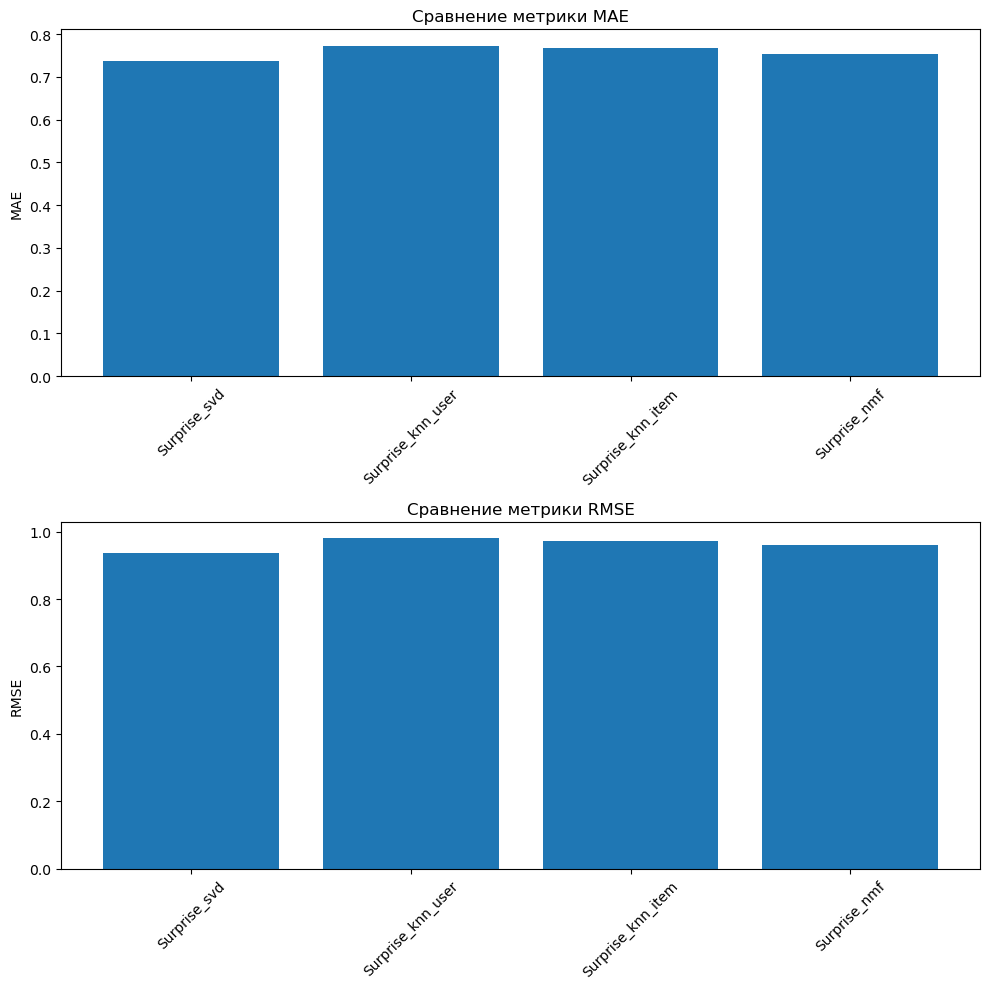

In [25]:
# Оценка моделей

evaluator = RecommenderEvaluator()
evaluator.add_recommender(surprise_svd)
evaluator.add_recommender(surprise_knn_user)
evaluator.add_recommender(surprise_knn_item)
evaluator.add_recommender(surprise_nmf)

metrics = evaluator.evaluate_all()

for model_name, model_metrics in metrics.items():
    print(f"\nМетрики для модели {model_name}:")
    for metric_name, value in model_metrics.items():
        print(f"  {metric_name}: {value:.4f}")


evaluator.plot_metrics()

In [26]:
user_id = 1  # ID пользователя для тестирования
print(f"\n=== Рекомендации для пользователя {user_id} ===")

# Получаем фильмы, которые пользователь уже оценил
user_ratings = data_loader.ratings[data_loader.ratings['userId'] == user_id]
user_movies = pd.merge(
    user_ratings,
    data_loader.movies[['movieId', 'title']],
    on='movieId'
).sort_values('rating', ascending=False)

print(f"\nПользователь {user_id} уже оценил следующие фильмы (топ-5):")
print(user_movies[['title', 'rating']].head(5))

# Получаем рекомендации от всех моделей
recommendations = evaluator.compare_recommendations(user_id)

# Выводим топ-5 рекомендаций от каждой модели
for name, recs in recommendations.items():
    print(f"\nТоп-5 рекомендаций от {name}:")
    print(recs.head(5))


=== Рекомендации для пользователя 1 ===

Пользователь 1 уже оценил следующие фильмы (топ-5):
                                      title  rating
17         Shawshank Redemption, The (1994)       5
270                          Sleeper (1973)       5
28                Breaking the Waves (1996)       5
32                Three Colors: Blue (1993)       5
33   Good, The Bad and The Ugly, The (1966)       5

Топ-5 рекомендаций от Surprise_svd:
   movieId                                              title  \
0      474  Dr. Strangelove or: How I Learned to Stop Worr...   
1      357             One Flew Over the Cuckoo's Nest (1975)   
2      603                                 Rear Window (1954)   
3      318                            Schindler's List (1993)   
4      513                              Third Man, The (1949)   

   predicted_rating  
0          4.937230  
1          4.936512  
2          4.925143  
3          4.690363  
4          4.676770  

Топ-5 рекомендаций от Surprise_kn

In [28]:


def analyze_genres(movie_ids, data_loader):
    """Анализирует распределение жанров в списке фильмов"""
    genre_names = [
        "Unknown", "Action", "Adventure", "Animation", "Children's",
        "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir",
        "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller",
        "War", "Western"
    ]

    genre_counts = {genre: 0 for genre in genre_names}

    for movie_id in movie_ids:
        movie = data_loader.movies[data_loader.movies['movieId'] == movie_id]
        if not movie.empty:
            for i, genre in enumerate(genre_names):
                if movie[f'genre_{i}'].values[0] == 1:
                    genre_counts[genre] += 1

    # Удаляем жанры с нулевым количеством
    return {k: v for k, v in genre_counts.items() if v > 0}

common_recs = evaluator.find_common_recommendations(recommendations)
print("\n=== Общие рекомендации всех систем ===")
if not common_recs.empty:
    print(common_recs)
else:
    print("Общих рекомендаций не найдено")

# Пример конкретных рекомендаций
print("\n=== Сравнение содержимого рекомендаций ===")
if 'Surprise_svd' in recommendations and 'LightFM_warp' in recommendations:
    surprise_genres = analyze_genres(
        recommendations['Surprise_svd']['movieId'].tolist()[:5],
        data_loader
    )

    lightfm_genres = analyze_genres(
        recommendations['LightFM_warp']['movieId'].tolist()[:5],
        data_loader
    )

    print("\nРаспределение жанров в рекомендациях Surprise:")
    for genre, count in surprise_genres.items():
        print(f"  {genre}: {count}")

    print("\nРаспределение жанров в рекомендациях LightFM:")
    for genre, count in lightfm_genres.items():
        print(f"  {genre}: {count}")





=== Общие рекомендации всех систем ===
Общих рекомендаций не найдено

=== Сравнение содержимого рекомендаций ===
